In [1]:
%cd ..


c:\Users\sussh\Documents\CODES\Python\python_phase2\Object_Detection


c:\Users\sussh\Documents\CODES\Python\python_phase2\Object_Detection\venv\Lib\site-packages\IPython\core\magics\osm.py:417: UserWarning: This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


## Import Packages

In [23]:
## Python in-built tools 
import os
import pickle
from tqdm import tqdm

## Data Science Tools 
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as patches 
%matplotlib inline

## Image Processing Tools 
import cv2
from torch.utils.data import Dataset, DataLoader 
import selectivesearch

## Frameworks
import torch 
import torch.nn as nn
from torchvision.ops import nms
from torchvision import transforms
from torchvision import models
from torchsummary import summary


In [3]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

## Hyper parameters


In [4]:
image_paths = "data/images/images"
csv_path = "data/df.csv"
batch_size = 2
n_epochs = 10
learning_rate = 1e-4
threshold_iou = 0.3


## Open Image Dataset Loading

In [5]:
class OpenImageDataset(Dataset):
    def __init__(self, image_paths, csv_path):
        super().__init__()
        self.image_paths = image_paths  
        self.csv_path = csv_path
        self.df = pd.read_csv(csv_path)
        self.unique_images = self.df['ImageID'].unique()
        print(self.unique_images[14]) 

    def __len__(self):
        return len(self.unique_images)
    
    def __getitem__(self, index):
        if isinstance(index, slice):
            # Get the list of indices from the slice
            # print("True")
            indices = range(*index.indices(len(self.unique_images)))
            return [self._load_item(i) for i in indices]
        else:
            return self._load_item(index)
    
    def _load_item(self, index):
        
        image_id = self.unique_images[index]
        image_full_path = os.path.join(self.image_paths, image_id + ".jpg")  
        image = cv2.imread(image_full_path, cv2.IMREAD_COLOR)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        h, w, _ = image.shape
        # print(h,w)

        # Filter dataframe for the corresponding image_id
        df = self.df.loc[self.df['ImageID'] == image_id]
        
        # Get bounding boxes and scale them based on image dimensions
        bboxes = df[['XMin', 'YMin', 'XMax', 'YMax']].values
        bboxes = (bboxes * np.array([w, h, w, h])).astype(np.uint16)
        # print(bboxes)
        # Get the class labels
        classes = df['LabelName'].values

        return image, bboxes, classes, image_full_path
datasets=OpenImageDataset(image_paths,csv_path)


000924a411c24d25


In [6]:
pd.read_csv(csv_path)


,ImageID,Source,LabelName,Confidence,XMin,XMax,YMin,YMax,IsOccluded,IsTruncated,...,IsDepiction,IsInside,XClick1X,XClick2X,XClick3X,XClick4X,XClick1Y,XClick2Y,XClick3Y,XClick4Y
0,0000599864fd15b3,xclick,Bus,1,0.343750,0.908750,0.156162,0.650047,1,0,...,0,0,0.421875,0.343750,0.795000,0.908750,0.156162,0.512700,0.650047,0.457197
1,00006bdb1eb5cd74,xclick,Truck,1,0.276667,0.697500,0.141604,0.437343,1,0,...,0,0,0.299167,0.276667,0.697500,0.659167,0.141604,0.241855,0.352130,0.437343
2,00006bdb1eb5cd74,xclick,Truck,1,0.702500,0.999167,0.204261,0.409774,1,1,...,0,0,0.849167,0.702500,0.906667,0.999167,0.204261,0.398496,0.409774,0.295739
3,00010bf498b64bab,xclick,Bus,1,0.156250,0.371250,0.269188,0.705228,0,0,...,0,0,0.274375,0.371250,0.311875,0.156250,0.269188,0.493882,0.705228,0.521691
4,00013f14dd4e168f,xclick,Bus,1,0.287500,0.999375,0.194184,0.999062,0,1,...,0,0,0.920000,0.999375,0.648750,0.287500,0.194184,0.303940,0.999062,0.523452
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24057,fff2b15ad6007d0e,activemil,Truck,1,0.277344,0.622656,0.226389,0.859722,0,0,...,0,0,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000
24058,fff376d20410e4c9,xclick,Bus,1,0.295625,0.558750,0.306667,0.397500,1,0,...,1,0,0.424375,0.316250,0.295625,0.558750,0.306667,0.397500,0.382500,0.335833
24059,fff376d20410e4c9,xclick,Bus,1,0.348125,0.701250,0.423333,0.744167,0,0,...,1,0,0.478750,0.493125,0.348125,0.701250,0.423333,0.744167,0.537500,0.523333
24060,fffde5953a818927,xclick,Bus,1,0.277500,0.605625,0.565000,0.795833,0,0,...,0,0,0.488125,0.277500,0.517500,0.605625,0.565000,0.670000,0.795833,0.704167


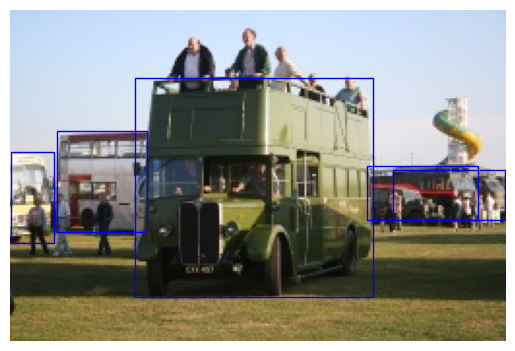

In [7]:
img, bbx, _, _ = datasets[14]
plt.imshow(img)
plt.axis('off')

for bb in bbx:
    rect = patches.Rectangle(bb[:2], bb[2]-bb[0], bb[3]-bb[1], edgecolor = 'b', facecolor = 'none', linewidth = 1)
    plt.gca().add_patch(rect)
plt.show()


## Utils Functions

In [8]:
def extract_candidates(img):
    _, regions = selectivesearch.selective_search(img, scale=4, min_size=20)
    candidates = []
    img_area = np.prod(img.shape[:2])
    for region in regions:
        if region['rect'] in candidates:
            continue
        if region['size'] < 0.05*img_area:
            continue
        if region['size'] > img_area:
            continue 
        candidates.append(region['rect'])
    return candidates

def extract_iou(bbox1, bbox2, epsilon=1e-5):
    x1 = max(bbox1[0], bbox2[0])
    y1 = max(bbox1[1], bbox2[1])
    
    x2 = min(bbox1[2], bbox2[2])
    y2 = min(bbox1[3], bbox2[3])

    width = x2 - x1
    height = y2 - y1

    if width < 0 or height < 0:
        return 0
    
    intersection_area = width * height 
    area_1 = (bbox1[2] - bbox1[0]) * (bbox1[3] - bbox1[1])
    area_2 = (bbox2[2] - bbox2[0]) * (bbox2[3] - bbox2[1])

    union_area = area_1 + area_2 - intersection_area
    return intersection_area / (union_area + epsilon)


In [ ]:
FULL_PATHS, GTBBS, CLSS, DELTAS, ROIS, IOUS = [], [], [], [], [], []
N = 15225
for i, (image, bboxes, classes, image_full_path) in enumerate(datasets):
    H, W, _ = image.shape
    candidates = extract_candidates(image)
    candidates = np.array([(x, y, x+w, y+h) for x, y, w, h in candidates])

    clss, deltas, rois = [], [], []
    ious = np.array([[extract_iou(candidate, bbox) for bbox in bboxes] for candidate in candidates])
    
    for j, candidate in enumerate (candidates):
        cx, cy, cX, cY = candidate
        candidate_ious = ious[j]
        best_iou_at = np.argmax(candidate_ious)
        best_iou = candidate_ious[best_iou_at]
        best_bb = _x, _y, _X, _Y = bboxes[best_iou_at]

        if best_iou > threshold_iou:
            clss.append(classes[best_iou_at])
        else:
            clss.append('background')

        delta = np.array([_x - cx, _y - cy, _X - cX, _Y - cY]) / np.array([W, H, W, H])
        deltas.append(delta)

        rois.append(candidate / np.array([W, H, W, H]))

    FULL_PATHS.append(image_full_path)
    GTBBS.append(bboxes)
    CLSS.append(clss)
    DELTAS.append(deltas)
    ROIS.append(rois)
    IOUS.append(ious)

In [5]:
#Multiprocessing

def extract_all(t):
    image, bboxes, classes, image_full_path = t
    H, W, _ = image.shape
    candidates = extract_candidates(image)
    candidates = np.array([(x, y, x+w, y+h) for x, y, w, h in candidates])

    clss, deltas, rois = [], [], []
    ious = np.array([[extract_iou(candidate, bbox) for bbox in bboxes] for candidate in candidates])
    
    for j, candidate in enumerate (candidates):
        cx, cy, cX, cY = candidate
        candidate_ious = ious[j]
        best_iou_at = np.argmax(candidate_ious)
        best_iou = candidate_ious[best_iou_at]
        best_bb = _x, _y, _X, _Y = bboxes[best_iou_at]

        if best_iou > threshold_iou:
            clss.append(classes[best_iou_at])
        else:
            clss.append('background')

        delta = np.array([_x - cx, _y - cy, _X - cX, _Y - cY]) / np.array([W, H, W, H])
        deltas.append(delta)

        rois.append(candidate / np.array([W, H, W, H]))

    return image_full_path, bboxes, clss, deltas, rois, ious

In [ ]:
from multiprocessing import Pool
FULL_PATHS, GTBBS, CLSS, DELTAS, ROIS, IOUS = [], [], [], [], [], []

with Pool(4) as p:
    results = p.imap(extract_all, datasets)
    for result in tqdm(results):
        image_full_path, bboxes, clss, deltas, rois, ious = result
        FULL_PATHS.append(image_full_path)
        GTBBS.append(bboxes)
        CLSS.append(clss)
        DELTAS.append(deltas)
        ROIS.append(rois)
        IOUS.append(ious)
        


## Pickle Utils Function


In [10]:
def save_pickle(var, path):
    with open(path, 'wb') as file:
        pickle.dump(var, file)

def load_pickle(path):
    with open(path, 'rb') as file:
        return pickle.load(file)

# save_pickle(FULL_PATHS, 'full_paths.pkl')
# save_pickle(GTBBS, 'gtbbs.pkl')
# save_pickle(CLSS, 'clss.pkl')
# save_pickle(DELTAS, 'deltas.pkl')
# save_pickle(ROIS, 'rois.pkl')
# save_pickle(IOUS, 'ious.pkl')



## Datasets for R-CNN

In [39]:
FULL_PATHS = load_pickle('full_paths.pkl')
# FULL_PATHS = [path.replace(r'C:\Users\sussh\Documents\CODES\Python\python_phase2\Object_Detection\data\images\images', '/kaggle/input/object-detection/data/images/images') for path in FULL_PATHS]
GTBBS = load_pickle('gtbbs.pkl')
CLSS = load_pickle('clss.pkl')
DELTAS = load_pickle('deltas.pkl')
ROIS = load_pickle('rois.pkl')
IOUS = load_pickle('ious.pkl')


In [12]:
unique_labels = np.unique(np.array([c for clss in CLSS for c in clss]))
target2label = {i: label for i, label in enumerate(unique_labels)}
label2target = {label: i for i, label in enumerate(unique_labels)}

print(target2label)
print(label2target)

background_class = label2target['background']
print(background_class)

{0: np.str_('Bus'), 1: np.str_('Truck'), 2: np.str_('background')}
{np.str_('Bus'): 0, np.str_('Truck'): 1, np.str_('background'): 2}
2


In [13]:
len(FULL_PATHS), len(GTBBS), len(CLSS), len(DELTAS), len(ROIS), len(IOUS)

(15225, 15225, 15225, 15225, 15225, 15225)

In [14]:
def preprocess(crop_img):
    crop_img = torch.tensor(crop_img).permute(2, 0, 1)
    normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    crop_img = normalize(crop_img)
    return crop_img.float()


class RCNNDataset(Dataset):
    def __init__(self, fpaths, rois, gtbbs, labels, deltas, ious):
        super().__init__()
        self.fpaths = fpaths
        self.rois = rois
        self.gtbbs = gtbbs
        self.labels = labels
        self.deltas = deltas
        self.ious = ious
        self.label2target = {'background': 0, 'bus': 1}

    def __len__(self):
        return len(self.fpaths)

    def __getitem__(self, index):
        fpath = self.fpaths[index]
        image = cv2.imread(fpath, cv2.IMREAD_COLOR)
        if image is None:
            raise FileNotFoundError(f"Image not found at path: {fpath}")
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        H, W, _ = image.shape

        gtbbs = self.gtbbs[index]

        rois = self.rois[index]
        bbs = (rois * np.array([W, H, W, H])).astype(np.uint8)
     
        crops = [image[y:Y, x:X] for x, y, X, Y in bbs]
        labels = self.labels[index]
        deltas = self.deltas[index]
        

        return image, gtbbs, bbs, crops, labels, deltas, fpath

    def collate_fn(self, batch):
        inputs, output_labels, output_deltas = [], [], []
        for i in range(len(batch)):
            image, gtbbs, bbs, crops, labels, deltas, fpath = batch[i]
            
            # Resize valid crops and preprocess them
            crops = [cv2.resize(crop,(224, 224)) for crop in crops ]
            crops = [preprocess(crop/255.0)[None] for crop in crops]
            
            inputs.extend(crops)
            output_labels.extend([label2target[label] for label in labels])
            output_deltas.extend(deltas)


        inputs = torch.cat(inputs).to(device)
        output_labels = torch.tensor(output_labels).long().to(device)
        output_deltas = torch.tensor(output_deltas).float().to(device)

        return inputs, output_labels, output_deltas


n_train = int(len(FULL_PATHS) * 0.8)

train_dataset = RCNNDataset(FULL_PATHS[:n_train], ROIS[:n_train], GTBBS[:n_train], CLSS[:n_train], DELTAS[:n_train], IOUS[:n_train])
test_dataset = RCNNDataset(FULL_PATHS[n_train:], ROIS[n_train:], GTBBS[n_train:], CLSS[n_train:], DELTAS[n_train:], IOUS[n_train:])


In [15]:
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=train_dataset.collate_fn)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True, collate_fn=test_dataset.collate_fn)


## Model Architecture


In [16]:
backbone = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V2)
# backbone.avgpool = nn.Sequential()
backbone.fc = nn.Sequential()

for param in backbone.parameters():
    param.requires_grad = False
backbone.to(device=device) 
summary(backbone.to(device), (3, 224, 224))

Layer (type:depth-idx)                   Output Shape              Param #
├─Conv2d: 1-1                            [-1, 64, 112, 112]        (9,408)
├─BatchNorm2d: 1-2                       [-1, 64, 112, 112]        (128)
├─ReLU: 1-3                              [-1, 64, 112, 112]        --
├─MaxPool2d: 1-4                         [-1, 64, 56, 56]          --
├─Sequential: 1-5                        [-1, 256, 56, 56]         --
|    └─Bottleneck: 2-1                   [-1, 256, 56, 56]         --
|    |    └─Conv2d: 3-1                  [-1, 64, 56, 56]          (4,096)
|    |    └─BatchNorm2d: 3-2             [-1, 64, 56, 56]          (128)
|    |    └─ReLU: 3-3                    [-1, 64, 56, 56]          --
|    |    └─Conv2d: 3-4                  [-1, 64, 56, 56]          (36,864)
|    |    └─BatchNorm2d: 3-5             [-1, 64, 56, 56]          (128)
|    |    └─ReLU: 3-6                    [-1, 64, 56, 56]          --
|    |    └─Conv2d: 3-7                  [-1, 256, 56, 56]  

Layer (type:depth-idx)                   Output Shape              Param #
├─Conv2d: 1-1                            [-1, 64, 112, 112]        (9,408)
├─BatchNorm2d: 1-2                       [-1, 64, 112, 112]        (128)
├─ReLU: 1-3                              [-1, 64, 112, 112]        --
├─MaxPool2d: 1-4                         [-1, 64, 56, 56]          --
├─Sequential: 1-5                        [-1, 256, 56, 56]         --
|    └─Bottleneck: 2-1                   [-1, 256, 56, 56]         --
|    |    └─Conv2d: 3-1                  [-1, 64, 56, 56]          (4,096)
|    |    └─BatchNorm2d: 3-2             [-1, 64, 56, 56]          (128)
|    |    └─ReLU: 3-3                    [-1, 64, 56, 56]          --
|    |    └─Conv2d: 3-4                  [-1, 64, 56, 56]          (36,864)
|    |    └─BatchNorm2d: 3-5             [-1, 64, 56, 56]          (128)
|    |    └─ReLU: 3-6                    [-1, 64, 56, 56]          --
|    |    └─Conv2d: 3-7                  [-1, 256, 56, 56]  

In [41]:
class RCNN(nn.Module):
    def __init__(self, backbone,n_classes):
        super().__init__()
        self.backbone = backbone
        self.n_classes = n_classes
        
        self.classification_head = nn.Linear(2048,n_classes)

        self.bbox_regression_head = nn.Sequential(
            nn.Linear(2048, 512),
            nn.ReLU(inplace=True),
            nn.Linear(512, 4),
            nn.Tanh()
        )
        self.classification_loss = nn.CrossEntropyLoss()
        self.localization_loss = nn.L1Loss()
        self.lmbda = 10.0  #prioritizes localization 
        
    def forward(self, inputs):
        feat = self.backbone(inputs)

        cls_score = self.classification_head(feat)
        
        deltas = self.bbox_regression_head(feat)
        
        return cls_score, deltas
    
    def calculate_loss(self, _labels, _deltas, actual_labels, actual_deltas):

        #classification loss
        classification_loss = self.classification_loss(_labels, actual_labels)
        #localization loss
        ix = torch.where(actual_labels != background_class)[0]
        _deltas = deltas[ix]
        actual_deltas = actual_deltas[ix]
        if len(ix) > 0:
            localization_loss = self.localization_loss(_deltas, actual_deltas)
        else:
            localization_loss = torch.tensor(0.0)
        
        total_loss = classification_loss + self.lmbda + localization_loss
        return total_loss, classification_loss, localization_loss

In [18]:
def train_batch(model, optimizer, inputs, actual_labels, deltas):
    model.train()
    optimizer.zero_grad()

    #Forward pass
    _labels, _deltas = model(inputs)
    total_loss, classification_loss, localization_loss = model.calculate_loss(_labels, _deltas, actual_labels, deltas)
    conf, pred_labels = _labels.max(-1)
    acc = pred_labels == actual_labels

    #Backward pass
    total_loss.backward()
    optimizer.step()
    return _labels, _deltas, total_loss, classification_loss, localization_loss, acc.cpu().numpy()

In [19]:
@torch.no_grad()
def validate_batch(model, inputs, actual_labels, deltas):
    model.eval()
    _labels, _deltas = model(inputs)
    total_loss, classification_loss, localization_loss = model.calculate_loss(_labels, _deltas, actual_labels, deltas)

    conf, pred_labels = _labels.max(-1)
    acc = pred_labels == actual_labels
    return _labels, _deltas, total_loss, classification_loss, localization_loss, acc.cpu().numpy()

In [20]:
rcnn = RCNN(backbone, 3).to(device=device)
optimizer = torch.optim.SGD(rcnn.parameters(), lr=learning_rate)

In [40]:
#training pipeline
train_history = {
  'total_loss' : [],
  'detection_loss' : [],
  'localization_loss' : [],
  'accuracy' : []
 }

test_history = {
    'total_loss' : [],
    'detection_loss' : [],
    'localization_loss' : [],
    'accuracy' : []
    }

for epoch in range(1, n_epochs+1):
    epoch_train_total_loss = 0
    epoch_train_detection_loss = 0
    epoch_train_localization_loss = 0
    epoch_train_accuracy = []

    for inputs, labels, deltas in tqdm(train_dataloader, desc=f"Training Epoch {epoch}/{n_epochs}"):
        _labels, _deltas, total_loss, classification_loss, localization_loss, acc = train_batch(rcnn, optimizer, inputs, labels, deltas)
        epoch_train_total_loss += total_loss.item()
        epoch_train_detection_loss += classification_loss.item()
        epoch_train_localization_loss += localization_loss.item()
        epoch_train_accuracy.extend(acc.tolist())

    epoch_train_total_loss /= len(train_dataloader)
    epoch_train_detection_loss /= len(train_dataloader)
    epoch_train_localization_loss /= len(train_dataloader)
    epoch_train_accuracy = np.mean(epoch_train_accuracy)

    epoch_test_total_loss = 0
    epoch_test_detection_loss = 0
    epoch_test_localization_loss = 0
    epoch_test_accuracy = []

    for inputs, labels, deltas in tqdm(test_dataloader, desc=f"Testing Epoch {epoch}/{n_epochs}"):
        _labels, _deltas, total_loss, classification_loss, localization_loss, acc = validate_batch(rcnn, inputs, labels, deltas)
        epoch_test_total_loss += total_loss.item()
        epoch_test_detection_loss += classification_loss.item()
        epoch_test_localization_loss += localization_loss.item()
        epoch_test_accuracy.extend(acc.tolist())

    epoch_test_total_loss /= len(test_dataloader)
    epoch_test_detection_loss /= len(test_dataloader)
    epoch_test_localization_loss /= len(test_dataloader)
    epoch_test_accuracy = sum(epoch_test_accuracy) / len(test_dataloader)

    train_history.get('total_loss').append(epoch_train_total_loss)
    train_history.get('detection_loss').append(epoch_train_detection_loss)
    train_history.get('localization_loss').append(epoch_train_localization_loss)
    train_history.get('accuracy').append(epoch_train_accuracy)

    test_history.get('total_loss').append(epoch_test_total_loss)
    test_history.get('detection_loss').append(epoch_test_detection_loss)
    test_history.get('localization_loss').append(epoch_test_localization_loss)
    test_history.get('accuracy').append(epoch_test_accuracy)

print(f"Epoch {epoch} of {n_epochs}, Training Loss: {epoch_train_total_loss}, Train Detection Loss: {epoch_train_detection_loss}, Training Localization Loss: {epoch_train_localization_loss}, Training Accuracy: {epoch_train_accuracy}, Test Loss: {epoch_test_total_loss}, Test Detection Loss: {epoch_test_detection_loss}, Test Localization Loss: {epoch_test_localization_loss}, Test Accuracy: {epoch_test_accuracy}")


Training Epoch 1/10:   1%|          | 73/6090 [00:18<25:24,  3.95it/s]


KeyboardInterrupt: 

In [ ]:
torch.save(rcnn, 'model.pth')

c:\Users\sussh\Documents\CODES\Python\python_phase2\Object_Detection\venv\Lib\site-packages\skimage\feature\texture.py:360: UserWarning: Applying `local_binary_pattern` to floating-point images may give unexpected results when small numerical differences between adjacent pixels are present. It is recommended to use this function with images of integer dtype.
  warnings.warn(


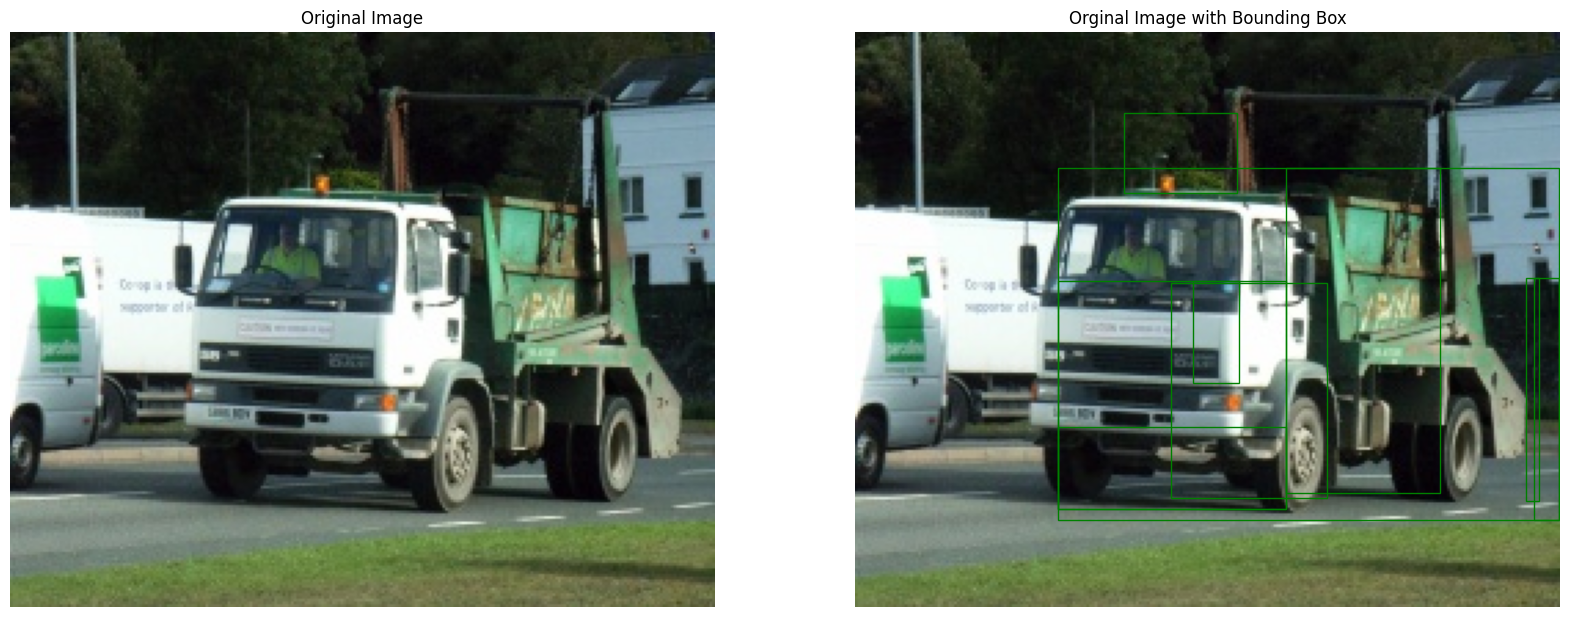

(array([0.40549546, 0.40521765, 0.39656097, 0.3752034 , 0.36959442,
        0.36887106, 0.35179734, 0.3483871 , 0.34029415], dtype=float32),
 array([2, 2, 2, 2, 2, 2, 2, 2, 2]),
 array([[0.33848333, 0.25602123, 0.40549546],
        [0.3281649 , 0.26661742, 0.40521765],
        [0.34463552, 0.25880358, 0.39656097],
        [0.33181322, 0.29298338, 0.3752034 ],
        [0.3424772 , 0.28792837, 0.36959442],
        [0.35742104, 0.2737079 , 0.36887106],
        [0.33053148, 0.3176712 , 0.35179734],
        [0.34812704, 0.30348593, 0.3483871 ],
        [0.32761446, 0.3320914 , 0.34029415]], dtype=float32),
 array([[ 73.        ,  48.94736842, 255.        , 177.        ],
        [114.        ,  90.94736842, 171.        , 169.        ],
        [ 73.        ,  89.94736842, 156.        , 173.        ],
        [246.        ,  88.94736842, 255.        , 177.        ],
        [ 73.        , 142.94736842, 156.        , 173.        ],
        [156.        ,  48.94736842, 212.        , 167.      

In [38]:
def read_and_preprocess(image_path):
    #Image Preprocessing and Make ready for inputs in model
    image = cv2.imread(image_path, cv2.IMREAD_COLOR)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    H, W, _ = image.shape
    candidates = extract_candidates(image)
    candidates = np.array([(x, y, x+w, y+h) for x, y, w, h in candidates])
    inputs = []

    for x, y, X, Y in candidates:
        crop = cv2.resize(image[y:Y, x:X], (224, 224))
        inputs.append(preprocess(crop/255.0)[None])
    return image, torch.cat(inputs).to(device), candidates, H, W


def predict(inputs):
        #Pass canidate to RCNN Model

    with torch.no_grad():
        rcnn.eval()
        labels, deltas = rcnn(inputs)
        probs = torch.nn.functional.softmax(labels, -1)
        conf, clss = probs.max(-1)

        return conf, clss, probs, deltas

def post_processing(conf, clss, probs, deltas, candidates, H, W):

    conf, clss, probs, deltas = [tensor.detach().cpu().numpy() for tensor in [conf, clss, probs, deltas]]

    #remove background classes and selection of non-background classes only
    indexes = clss == background_class
    conf, clss, probs, deltas, candidates = [tensor[indexes] for tensor in [conf, clss, probs, deltas, candidates]]

    bboxes = (delta * np.array([W, H, W, H])) + candidates
    bboxes.astype(np.uint16)

    ix = nms(torch.tensor(bboxes.astype(np.float32)), torch.tensor(conf), iou_threshold=0.5)
    return [tensor[ix] for tensor in [conf, clss, probs, deltas, candidates, bboxes]]
                    
def test_prediction(image_path, display= True):

    image, inputs, candidates, image_height, image_width = read_and_preprocess(image_path)

    conf, clss, probs, deltas = predict(inputs)
    conf, clss, probs, deltas, candidates, bboxes = post_processing(conf, clss, probs, deltas, candidates, H, W)

    if display:
        fig, ax = plt.subplots(1,2, figsize=(20,10))
        ax[0].imshow(image)
        ax[0].axis('off')
        ax[0].grid(False)
        ax[0].set_title('Original Image')

        ax[1].imshow(image)
        ax[1].axis('off')
        ax[1].grid(False)
        ax[1].set_title('Orginal Image with Bounding Box')
        for bb, cls in zip(bboxes, clss):
            color = {0: 'b', 1: 'r', 2: 'g'}
            rect = patches.Rectangle(bb[:2], bb[2]-bb[0], bb[3]-bb[1], edgecolor = color.get(cls), facecolor = 'none', linewidth = 1)
            ax[1].add_patch(rect)
    plt.show()
    return conf, clss, probs, bboxes


test_prediction('test1.jpg')



In [ ]:
class InferenceRCNN:
    def __init__(self) -> None:
        self.rcnn = torch.load('model.pth')

    def prepro